In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightfm import LightFM

import os
import json
import copy

from lightfm.evaluation import precision_at_k, auc_score , reciprocal_rank
import scipy
import time
import math
from lightfm.data import Dataset

import seaborn as sns
%matplotlib inline

In [236]:
# load datasets
item_features = pd.read_excel('data/item_feature_table.xlsx')
item_user_interactions = pd.read_excel('data/item_user_interactions.xlsx')

In [237]:
print('Shape of item features and user-item interactions datasets:')
print(item_features.shape)
print(item_user_interactions.shape)

Shape of item features and user-item interactions datasets:
(155, 55)
(11, 156)


In [238]:
item_features.head(10)

,Name,Category,SubCategory,Cuisine,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,...,Good for kids,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food
0,The Full MoonThe Attic Bar,Pub,NaN,"Pizza, Tacos",Y,Y,Y,Y,N,N,...,N,N,Y,Y,Y,NaN,Y,Y,NaN,NaN
1,Pieminister,Restaurant,British Restaurant,Pies,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,Y,Y,NaN,NaN,NaN
2,Caribbean Croft,Restaurant,Caribbean Restaurant,Caribbean,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,NaN,Y,NaN,Y,NaN
3,Tuk Tuck,Restaurant,Korean Restaurant,Korean Street Food,Y,Y,N,N,Y,N,...,NaN,N,N,N,NaN,Y,Y,NaN,NaN,NaN
4,The Spaghetti Incident,Restaurant,Italian Restaurant,Italian,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,Y,NaN,NaN,NaN,NaN
5,The Viet Kitchen,Restaurant,Vietnamese Restaurant,col,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,NaN,Y,NaN,N,NaN
6,Marina Restaurant,Restaurant,NaN,"Middle Eastern, Mediterranean",Y,Y,N,N,Y,N,...,NaN,Y,N,N,NaN,NaN,Y,Y,N,NaN
7,No.51,Bar,Bar and Restaurant,"Pizza, Burgers",Y,Y,Y,Y,N,Y,...,NaN,N,Y,Y,Y,NaN,Y,NaN,NaN,NaN
8,Om Burger,Restaurant,Vegan Restaurant,Vegan,Y,Y,Y,Y,Y,N,...,NaN,N,N,N,NaN,Y,Y,Y,N,NaN
9,Falafel Time,Takeaway,Middle Eatern Restaurant,Middle Eastern,Y,Y,N,N,Y,N,...,NaN,N,N,N,NaN,N,Y,Y,N,NaN


In [239]:
item_user_interactions.head(10)

,Name,The Full MoonThe Attic Bar,Pieminister,Caribbean Croft,Tuk Tuck,The Spaghetti Incident,The Viet Kitchen,Marina Restaurant,No.51,Om Burger,...,FED,Achari Indian Kitchen,Jubo Raj,Pasta Loco,Crying Wolf,Rock Salt,Muiño,Brewhouse & Kitchen,Rubicon Too,Bravas
0,Person A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Person B,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Person C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Person D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Person E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Person F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Person G,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Person H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Person I,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Person J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
item_features.isnull().sum()

Name                        0
Category                    2
SubCategory                57
Cuisine                    10
Dine in                     6
Serves food                 7
Serves alcohol             11
Drinks only                14
Primarily food              5
Primarily drinks            7
Cocktails                  37
beer                       13
Craft Beer                 77
Draft Beer                 64
Spirits                    27
Wine menu                  16
Outdoor seating            11
Takeaway drinks            19
Heater                     47
By river                    6
LGBT+ Friendly            121
Family Friendly            88
Student friendly          126
Wheelchair accessible      61
Rooftop                     5
Good views                  8
Atmospheric                61
Cosy                       16
Trendy                      8
Hip                        31
Quirky                      8
Rustic                     15
Casual                      5
Smart     

In [241]:
item_user_interactions.isnull().sum()

Name                           0
The Full MoonThe Attic Bar     9
Pieminister                   10
Caribbean Croft               10
Tuk Tuck                      11
                              ..
Rock Salt                     11
Muiño                         11
Brewhouse & Kitchen           11
Rubicon Too                   11
Bravas                        11
Length: 156, dtype: int64

In [242]:
item_user_interactions.columns

Index(['Name ', 'The Full MoonThe Attic Bar', 'Pieminister', 'Caribbean Croft',
       'Tuk Tuck', 'The Spaghetti Incident', 'The Viet Kitchen',
       'Marina Restaurant', 'No.51', 'Om Burger',
       ...
       'FED', 'Achari Indian Kitchen', 'Jubo Raj', 'Pasta Loco', 'Crying Wolf',
       'Rock Salt', 'Muiño', 'Brewhouse & Kitchen', 'Rubicon Too', 'Bravas'],
      dtype='object', length=156)

In [243]:
item_features.columns

Index(['Name ', 'Category', 'SubCategory', 'Cuisine', 'Dine in', 'Serves food',
       'Serves alcohol', 'Drinks only', 'Primarily food', 'Primarily drinks',
       'Cocktails', 'beer ', 'Craft Beer', 'Draft Beer', 'Spirits',
       'Wine menu ', 'Outdoor seating', 'Takeaway drinks', 'Heater',
       'By river', 'LGBT+ Friendly', 'Family Friendly', 'Student friendly',
       'Wheelchair accessible ', 'Rooftop', 'Good views', 'Atmospheric ',
       'Cosy', 'Trendy', 'Hip', 'Quirky', 'Rustic', 'Casual', 'Smart',
       'Lively', 'Fine Dining', 'Relaxed', 'Authentic', 'Snug', 'Industrial',
       'Impressive', 'No Frills', 'Independent', 'Happy Hour Food',
       'Happy Hour Drinks', 'Good for kids', 'Children's menu', 'Live Music',
       'DJs', 'Pop-up Events', 'WiFi', 'Vegetrian Options', 'Vegan Options',
       'Fireplace', 'Late-night Food'],
      dtype='object')

In [244]:
# calculate sparsity
utility_df = item_user_interactions.drop('Name ', axis=1)
total_non_null = np.sum(utility_df.count())
sparsity = float(total_non_null) / float(utility_df.shape[0]*utility_df.shape[1])*100
print('Sparsity:{:4.3f}%'.format(sparsity))

Sparsity:2.170%


In [245]:
utility_df.head(10)

,The Full MoonThe Attic Bar,Pieminister,Caribbean Croft,Tuk Tuck,The Spaghetti Incident,The Viet Kitchen,Marina Restaurant,No.51,Om Burger,Falafel Time,...,FED,Achari Indian Kitchen,Jubo Raj,Pasta Loco,Crying Wolf,Rock Salt,Muiño,Brewhouse & Kitchen,Rubicon Too,Bravas
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
item_features.head(10)


,Name,Category,SubCategory,Cuisine,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,...,Good for kids,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food
0,The Full MoonThe Attic Bar,Pub,NaN,"Pizza, Tacos",Y,Y,Y,Y,N,N,...,N,N,Y,Y,Y,NaN,Y,Y,NaN,NaN
1,Pieminister,Restaurant,British Restaurant,Pies,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,Y,Y,NaN,NaN,NaN
2,Caribbean Croft,Restaurant,Caribbean Restaurant,Caribbean,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,NaN,Y,NaN,Y,NaN
3,Tuk Tuck,Restaurant,Korean Restaurant,Korean Street Food,Y,Y,N,N,Y,N,...,NaN,N,N,N,NaN,Y,Y,NaN,NaN,NaN
4,The Spaghetti Incident,Restaurant,Italian Restaurant,Italian,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,Y,NaN,NaN,NaN,NaN
5,The Viet Kitchen,Restaurant,Vietnamese Restaurant,col,Y,Y,Y,N,Y,N,...,NaN,N,N,N,NaN,NaN,Y,NaN,N,NaN
6,Marina Restaurant,Restaurant,NaN,"Middle Eastern, Mediterranean",Y,Y,N,N,Y,N,...,NaN,Y,N,N,NaN,NaN,Y,Y,N,NaN
7,No.51,Bar,Bar and Restaurant,"Pizza, Burgers",Y,Y,Y,Y,N,Y,...,NaN,N,Y,Y,Y,NaN,Y,NaN,NaN,NaN
8,Om Burger,Restaurant,Vegan Restaurant,Vegan,Y,Y,Y,Y,Y,N,...,NaN,N,N,N,NaN,Y,Y,Y,N,NaN
9,Falafel Time,Takeaway,Middle Eatern Restaurant,Middle Eastern,Y,Y,N,N,Y,N,...,NaN,N,N,N,NaN,N,Y,Y,N,NaN


In [247]:
utility_df.shape

(11, 155)

In [248]:
item_features.fillna('unk', inplace=True)
item_features.head(10)

# change to lowercase
def lowercase_text(x):
    try:
        x = x.lower()
    except:
        pass
    return x

item_cat_cols = ['Category', 'SubCategory', 'Cuisine']
for col in item_cat_cols:
    item_features[col] = item_features[col].apply(lowercase_text)

In [249]:
item_features['Category'].value_counts()

restaurant     44
pub            29
café           28
restaurant     19
takeaway       18
bar            10
brewery         3
nightclub       2
unk             2
Name: Category, dtype: int64

In [250]:
item_features['SubCategory'].value_counts()

unk                              57
traditional english pub          15
indian restaurant                 5
italian restaurant                4
late night food                   3
caribbean restaurant              3
cocktail bar                      3
bakery and café                   3
hamburger restaurant              3
brewery tap room                  3
vegan restaurant                  3
vietnamese restaurant             2
korean restaurant                 2
jamaican restaurant               2
middle eatern restaurant          2
pizzeria                          2
sri lankan restaurant             1
rustic café                       1
persian restaurant                1
hotel restaurant                  1
small bistro                      1
restaurant bar                    1
indian café                       1
sports bar                        1
fish and seafood restaurant       1
canteen style bar                 1
polish restaurant                 1
board game bar              

In [251]:
item_features['Cuisine'].value_counts()

unk                         10
pizza                        7
modern british               7
fast food                    6
indian                       5
                            ..
polish                       1
turkish, meze                1
sandwiches, cake             1
british                      1
superfood, smoothie bowl     1
Name: Cuisine, Length: 98, dtype: int64

In [252]:
item_features_clean = item_features.copy()

In [253]:
def encoding(x):
    if x =='Y':
        code = 1
    elif x == 'N':
        code = -1
    else:
        code = 0
    return code

In [254]:
item_features_cols = item_features_clean.columns.tolist()
remove_cols_list = ['Name ','Category', 'SubCategory', 'Cuisine']
for col in remove_cols_list: item_features_cols.remove(col)


In [255]:
item_features_clean.shape

(155, 55)

In [256]:
for col in item_features_cols:
    item_features_clean[col] = item_features_clean[col].apply(encoding)

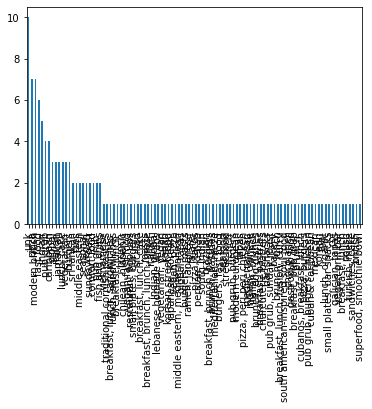

In [257]:
item_features_clean['Cuisine'].value_counts().plot(kind="bar")

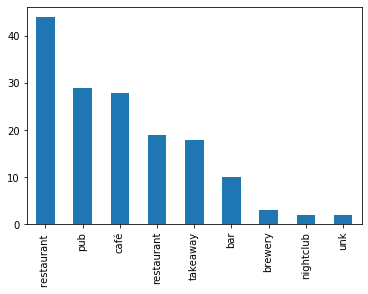

In [258]:
item_features_clean['Category'].value_counts().plot(kind="bar")


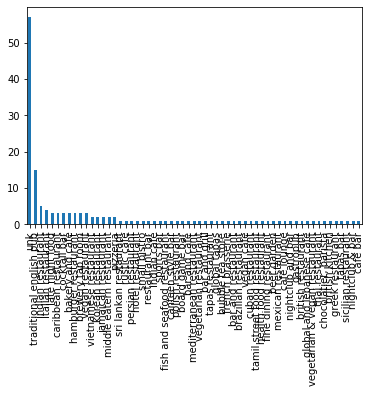

In [259]:
item_features_clean['SubCategory'].value_counts().plot(kind="bar")

In [260]:
numeric_item_features_clean = item_features_clean[item_features_cols]

In [261]:
numeric_item_features_clean.describe()

,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,beer,Craft Beer,Draft Beer,...,Good for kids,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,0.709677,0.870968,0.412903,0.264516,0.258065,-0.567742,-0.180645,0.400000,0.012903,0.135484,...,0.258065,-0.522581,-0.567742,-0.619355,-0.387097,-0.032258,0.606452,0.251613,-0.432258,-0.083871
std,0.673889,0.437075,0.873767,0.919327,0.952363,0.797882,0.856381,0.872375,0.711566,0.756594,...,0.682230,0.657973,0.756095,0.676805,0.776164,0.724518,0.540524,0.529562,0.603231,0.692772
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


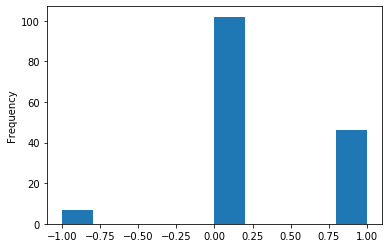

In [262]:
numeric_item_features_clean['Vegan Options'].plot.hist()


In [263]:
#item_features_clean = pd.concat([item_features_clean, item_features_clean['Cuisine']
#                                 .str.get_dummies(sep=',')], axis = 1).drop('Cuisine', 1)
#list_cuisines = ['cuisine 1']
#item_features_clean[list_cuisines] = item_features_clean['Cuisine'].str.split(',', n=1, expand=True)
item_features_clean.drop('Cuisine', 1, inplace=True)

In [264]:
item_features_clean.shape

(155, 54)

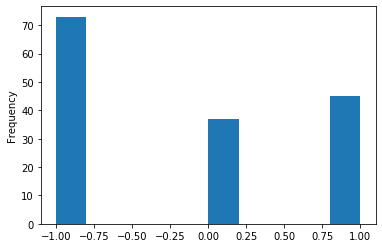

In [265]:
numeric_item_features_clean['Cocktails'].plot.hist()

In [266]:
item_features_clean.rename(columns = {'Name ':'business_name'}, inplace=True)

In [267]:
item_features_clean.head(10)

,business_name,Category,SubCategory,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,...,Good for kids,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food
0,The Full MoonThe Attic Bar,pub,unk,1,1,1,1,-1,-1,-1,...,-1,-1,1,1,1,0,1,1,0,0
1,Pieminister,restaurant,british restaurant,1,1,1,-1,1,-1,1,...,0,-1,-1,-1,0,1,1,0,0,0
2,Caribbean Croft,restaurant,caribbean restaurant,1,1,1,-1,1,-1,1,...,0,-1,-1,-1,0,0,1,0,1,0
3,Tuk Tuck,restaurant,korean restaurant,1,1,-1,-1,1,-1,-1,...,0,-1,-1,-1,0,1,1,0,0,0
4,The Spaghetti Incident,restaurant,italian restaurant,1,1,1,-1,1,-1,-1,...,0,-1,-1,-1,0,1,0,0,0,0
5,The Viet Kitchen,restaurant,vietnamese restaurant,1,1,1,-1,1,-1,-1,...,0,-1,-1,-1,0,0,1,0,-1,0
6,Marina Restaurant,restaurant,unk,1,1,-1,-1,1,-1,-1,...,0,1,-1,-1,0,0,1,1,-1,0
7,No.51,bar,bar and restaurant,1,1,1,1,-1,1,1,...,0,-1,1,1,1,0,1,0,0,0
8,Om Burger,restaurant,vegan restaurant,1,1,1,1,1,-1,-1,...,0,-1,-1,-1,0,1,1,1,-1,0
9,Falafel Time,takeaway,middle eatern restaurant,1,1,-1,-1,1,-1,-1,...,0,-1,-1,-1,0,-1,1,1,-1,0


In [268]:
# Processing User information
item_user_interactions.columns.isin(item_features_clean.iloc[:,1])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [269]:
item_user_interactions.head(10)

,Name,The Full MoonThe Attic Bar,Pieminister,Caribbean Croft,Tuk Tuck,The Spaghetti Incident,The Viet Kitchen,Marina Restaurant,No.51,Om Burger,...,FED,Achari Indian Kitchen,Jubo Raj,Pasta Loco,Crying Wolf,Rock Salt,Muiño,Brewhouse & Kitchen,Rubicon Too,Bravas
0,Person A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Person B,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Person C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Person D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Person E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Person F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Person G,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Person H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Person I,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Person J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [270]:
item_user_interactions.fillna(0, inplace=True)

In [271]:
# Change format to review dataframe
item_user_visits = item_user_interactions.copy()
item_user_visits.set_index('Name ', inplace= True)
item_user_visits = item_user_visits[item_user_visits == 1].stack().reset_index().drop(0,1)
item_user_visits.rename(columns = {'level_1':'business_name'}, inplace=True)

In [272]:
item_user_visits_cols = item_features_cols

add_cols_list = ['Name ','business_name']
for col in add_cols_list: item_user_visits_cols.append(col)

In [273]:
# create similar structure like Data review
item_users_interactions = item_user_visits.merge(item_features_clean, on='business_name')

item_users_interactions = item_users_interactions[item_user_visits_cols]


In [274]:
item_users_interactions.head(36)

,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,beer,Craft Beer,Draft Beer,...,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food,Name,business_name
0,1,1,1,1,1,-1,1,1,0,0,...,-1,-1,0,0,1,1,-1,1,Person A,Poco Tapas Bar
1,1,1,1,1,1,-1,1,1,0,0,...,-1,-1,0,0,1,1,-1,1,Person D,Poco Tapas Bar
2,1,1,1,1,1,-1,1,1,0,0,...,-1,-1,0,0,1,1,-1,1,Person F,Poco Tapas Bar
3,1,1,1,1,1,-1,1,1,0,0,...,-1,-1,0,0,1,1,-1,1,Person G,Poco Tapas Bar
4,1,1,1,1,1,-1,1,1,0,0,...,-1,-1,0,0,1,1,-1,1,Person K,Poco Tapas Bar
5,1,1,1,1,1,-1,-1,1,0,0,...,-1,-1,1,1,1,0,-1,0,Person A,Crafty Egg
6,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,-1,0,0,-1,0,Person A,Bianchis
7,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,-1,0,0,-1,0,Person B,Bianchis
8,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,-1,0,0,-1,0,Person F,Bianchis
9,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,-1,0,0,-1,0,Person J,Bianchis


In [275]:
item_users_interactions.rename(columns={'Name ':'user_name'}, inplace=True)

In [276]:
# check sparcity
n_users = item_users_interactions['user_name'].unique().shape[0]
n_items = item_users_interactions['business_name'].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(item_users_interactions.shape[0])/float(n_users*n_items)*100))

Number of users: 8
Number of items: 24
Sparsity: 19.271%


In [277]:
# check user interactions distribution
tmp_user = item_users_interactions.groupby('user_name')['business_name'].count().reset_index()
tmp_user.describe() # many users do not have much interactions, a serious cold start problem as expected.

,business_name
count,8.00000
mean,4.62500
std,1.06066
min,2.00000
25%,5.00000
50%,5.00000
75%,5.00000
max,5.00000


In [278]:
tmp_user

,user_name,business_name
0,Person A,5
1,Person B,5
2,Person D,2
3,Person F,5
4,Person G,5
5,Person I,5
6,Person J,5
7,Person K,5


In [279]:
data_user = item_users_interactions.groupby('user_name').sum().reset_index()
data_user = data_user.merge(tmp_user, on='user_name')
data_user.rename(columns={'business_name':'places_visited_count'}, inplace=True)

In [280]:
data_user

,user_name,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,beer,Craft Beer,...,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food,places_visited_count
0,Person A,5,5,5,3,1,-3,2,5,2,...,1,-5,-3,1,0,3,1,-4,0,5
1,Person B,5,5,5,1,-1,1,2,5,1,...,-3,-3,-3,-1,0,2,1,-1,-2,5
2,Person D,2,2,2,0,2,-2,2,2,0,...,1,-2,-2,0,-1,2,1,-2,2,2
3,Person F,5,5,5,1,3,-3,4,5,3,...,-2,-3,-3,-2,-3,2,2,-2,0,5
4,Person G,5,4,5,3,-1,-1,1,5,1,...,-1,-2,-2,1,1,4,3,2,0,5
5,Person I,5,5,1,5,-1,-3,-3,1,-1,...,-2,1,0,2,0,4,4,-2,-1,5
6,Person J,5,5,5,-3,3,-3,2,5,3,...,-4,-5,-5,-4,-1,1,1,-4,-3,5
7,Person K,5,5,5,5,1,-3,3,5,3,...,-1,-1,-3,1,0,4,4,-3,1,5


In [281]:
data_user.columns

Index(['user_name', 'Dine in', 'Serves food', 'Serves alcohol', 'Drinks only',
       'Primarily food', 'Primarily drinks', 'Cocktails', 'beer ',
       'Craft Beer', 'Draft Beer', 'Spirits', 'Wine menu ', 'Outdoor seating',
       'Takeaway drinks', 'Heater', 'By river', 'LGBT+ Friendly',
       'Family Friendly', 'Student friendly', 'Wheelchair accessible ',
       'Rooftop', 'Good views', 'Atmospheric ', 'Cosy', 'Trendy', 'Hip',
       'Quirky', 'Rustic', 'Casual', 'Smart', 'Lively', 'Fine Dining',
       'Relaxed', 'Authentic', 'Snug', 'Industrial', 'Impressive', 'No Frills',
       'Independent', 'Happy Hour Food', 'Happy Hour Drinks', 'Good for kids',
       'Children's menu', 'Live Music', 'DJs', 'Pop-up Events', 'WiFi',
       'Vegetrian Options', 'Vegan Options', 'Fireplace', 'Late-night Food',
       'places_visited_count'],
      dtype='object')

In [282]:
tmp_item = item_users_interactions.groupby(['business_name']).count().reset_index()
tmp_item.rename(columns={'user_name':'visits_count'}, inplace=True)

In [283]:
tmp_item = tmp_item[['business_name','visits_count']]

In [284]:
item_features_clean = item_features_clean.merge(tmp_item, on='business_name', how='left')

In [285]:
item_features_clean.fillna(0,inplace=True)

In [286]:
item_features_clean

,business_name,Category,SubCategory,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,...,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food,visits_count
0,The Full MoonThe Attic Bar,pub,unk,1,1,1,1,-1,-1,-1,...,-1,1,1,1,0,1,1,0,0,2.0
1,Pieminister,restaurant,british restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,0,1,1,0,0,0,1.0
2,Caribbean Croft,restaurant,caribbean restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,0,0,1,0,1,0,1.0
3,Tuk Tuck,restaurant,korean restaurant,1,1,-1,-1,1,-1,-1,...,-1,-1,-1,0,1,1,0,0,0,0.0
4,The Spaghetti Incident,restaurant,italian restaurant,1,1,1,-1,1,-1,-1,...,-1,-1,-1,0,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Rock Salt,restaurant,unk,1,1,1,-1,1,-1,1,...,-1,-1,-1,-1,1,1,1,-1,1,0.0
151,Muiño,restaurant,tapas restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,-1,0,1,0,-1,0,0.0
152,Brewhouse & Kitchen,pub,unk,1,1,1,1,-1,1,1,...,1,-1,-1,1,0,1,1,0,0,0.0
153,Rubicon Too,café,unk,0,0,-1,1,-1,-1,-1,...,0,-1,-1,-1,0,0,0,-1,-1,0.0


In [287]:
item_users_interactions['implicit_feedback'] = 1

In [288]:
item_users_interactions

,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,beer,Craft Beer,Draft Beer,...,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food,user_name,business_name,implicit_feedback
0,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person A,Poco Tapas Bar,1
1,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person D,Poco Tapas Bar,1
2,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person F,Poco Tapas Bar,1
3,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person G,Poco Tapas Bar,1
4,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person K,Poco Tapas Bar,1
5,1,1,1,1,1,-1,-1,1,0,0,...,-1,1,1,1,0,-1,0,Person A,Crafty Egg,1
6,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person A,Bianchis,1
7,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person B,Bianchis,1
8,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person F,Bianchis,1
9,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person J,Bianchis,1


### Recommender model

In [289]:
# model 
dataset = Dataset()
dataset.fit(item_users_interactions.user_name, item_users_interactions.business_name)
type(dataset)
num_users, num_items = dataset.interactions_shape()
print('Num users:{}, num_items{}.'.format(num_users, num_items))

Num users:8, num_items24.


### fit item and user features

In [290]:
# Business 
data_business = item_features_clean.copy()

dataset.fit_partial(items=data_business.business_name,
                   item_features=['visits_count'])


In [291]:
data_business.head(5)

,business_name,Category,SubCategory,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,...,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food,visits_count
0,The Full MoonThe Attic Bar,pub,unk,1,1,1,1,-1,-1,-1,...,-1,1,1,1,0,1,1,0,0,2.0
1,Pieminister,restaurant,british restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,0,1,1,0,0,0,1.0
2,Caribbean Croft,restaurant,caribbean restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,0,0,1,0,1,0,1.0
3,Tuk Tuck,restaurant,korean restaurant,1,1,-1,-1,1,-1,-1,...,-1,-1,-1,0,1,1,0,0,0,0.0
4,The Spaghetti Incident,restaurant,italian restaurant,1,1,1,-1,1,-1,-1,...,-1,-1,-1,0,1,0,0,0,0,0.0


In [292]:
data_business.columns

Index(['business_name', 'Category', 'SubCategory', 'Dine in', 'Serves food',
       'Serves alcohol', 'Drinks only', 'Primarily food', 'Primarily drinks',
       'Cocktails', 'beer ', 'Craft Beer', 'Draft Beer', 'Spirits',
       'Wine menu ', 'Outdoor seating', 'Takeaway drinks', 'Heater',
       'By river', 'LGBT+ Friendly', 'Family Friendly', 'Student friendly',
       'Wheelchair accessible ', 'Rooftop', 'Good views', 'Atmospheric ',
       'Cosy', 'Trendy', 'Hip', 'Quirky', 'Rustic', 'Casual', 'Smart',
       'Lively', 'Fine Dining', 'Relaxed', 'Authentic', 'Snug', 'Industrial',
       'Impressive', 'No Frills', 'Independent', 'Happy Hour Food',
       'Happy Hour Drinks', 'Good for kids', 'Children's menu', 'Live Music',
       'DJs', 'Pop-up Events', 'WiFi', 'Vegetrian Options', 'Vegan Options',
       'Fireplace', 'Late-night Food', 'visits_count'],
      dtype='object')

In [293]:
data_business.columns[3:-1]

Index(['Dine in', 'Serves food', 'Serves alcohol', 'Drinks only',
       'Primarily food', 'Primarily drinks', 'Cocktails', 'beer ',
       'Craft Beer', 'Draft Beer', 'Spirits', 'Wine menu ', 'Outdoor seating',
       'Takeaway drinks', 'Heater', 'By river', 'LGBT+ Friendly',
       'Family Friendly', 'Student friendly', 'Wheelchair accessible ',
       'Rooftop', 'Good views', 'Atmospheric ', 'Cosy', 'Trendy', 'Hip',
       'Quirky', 'Rustic', 'Casual', 'Smart', 'Lively', 'Fine Dining',
       'Relaxed', 'Authentic', 'Snug', 'Industrial', 'Impressive', 'No Frills',
       'Independent', 'Happy Hour Food', 'Happy Hour Drinks', 'Good for kids',
       'Children's menu', 'Live Music', 'DJs', 'Pop-up Events', 'WiFi',
       'Vegetrian Options', 'Vegan Options', 'Fireplace', 'Late-night Food'],
      dtype='object')

In [294]:
tar_cols = [x for x in data_business.columns[3:-1]]

dataset.fit_partial(items = data_business.business_name,
                   item_features = tar_cols)

In [295]:
# Users
user_cols = [x for x in data_user.columns[1:]]
dataset.fit_partial(users = data_user.user_name,
                    user_features = user_cols)

In [296]:
# check data
print(type(dataset))
print(dataset.model_dimensions())
print(dataset.user_features_shape())
print(dataset.item_features_shape())
print(dataset.interactions_shape())

<class 'lightfm.data.Dataset'>
(60, 207)
(8, 60)
(155, 207)
(8, 155)


In [297]:
# look at item feature mapping
a = dataset.mapping()[3]
list(a.items())[0:10]


[('Poco Tapas Bar', 0),
 ('Crafty Egg', 1),
 ('Bianchis', 2),
 ('Filthy XIII', 3),
 ('Hillgrove Porter Stores', 4),
 ('Pieminister', 5),
 ('The Cadbury House', 6),
 ('Cosies', 7),
 ('Café Cuba', 8),
 ('The Bristolian', 9)]

In [298]:
item_users_interactions

,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,beer,Craft Beer,Draft Beer,...,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food,user_name,business_name,implicit_feedback
0,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person A,Poco Tapas Bar,1
1,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person D,Poco Tapas Bar,1
2,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person F,Poco Tapas Bar,1
3,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person G,Poco Tapas Bar,1
4,1,1,1,1,1,-1,1,1,0,0,...,-1,0,0,1,1,-1,1,Person K,Poco Tapas Bar,1
5,1,1,1,1,1,-1,-1,1,0,0,...,-1,1,1,1,0,-1,0,Person A,Crafty Egg,1
6,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person A,Bianchis,1
7,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person B,Bianchis,1
8,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person F,Bianchis,1
9,1,1,1,-1,1,-1,1,1,1,0,...,-1,-1,-1,0,0,-1,0,Person J,Bianchis,1


In [299]:
"""
Build a item features matrix out of an iterable of the form (item id, [list of feature names]) or 
(item id, {feature name: feature weight}).

Parameters:
data (iterable of the form) – (item id, [list of feature names]) or (item id, {feature name: feature weight}). 
Item and feature ids will be translated to internal indices constructed during the fit call.
normalize (bool, optional) – If true, will ensure that feature weights sum to 1 in every row.
Returns:
feature matrix – Matrix of item features.

Return type:
CSR matrix (num items, num features)
"""

#build interaction
(interactions, weights) = dataset.build_interactions([(x['user_name'],
                                                       x['business_name'],
                                                       x['implicit_feedback']) for index,x in 
                                                      item_users_interactions.iterrows()])

print(repr(interactions))

<8x155 sparse matrix of type '<class 'numpy.int32'>'
	with 37 stored elements in COOrdinate format>


In [300]:

# build user and item features

def build_dict(df,tar_cols,val_list):
    rst = {}
    for col in tar_cols:
        rst[col] = df[col]
    sum_val = sum(list(rst.values())) # get sum of all the tfidf values
    
    if(sum_val == 0):
        return rst
    else:
        
        w = (2-sum(val_list))/sum_val # weight for each tag to be able to sum to 1
        for key,value in rst.items():
            rst[key] = value * w
    return rst

def user_build_dict(df,tar_cols,val_list):
    rst = {}
    for col in tar_cols:
        rst[col] = df[col]
    sum_val = sum(list(rst.values())) # get sum of all the tfidf values
    
    if(sum_val == 0):
        return rst
    else:
        w = (2-sum(val_list))/sum_val # weight for each tag to be able to sum to 1
        for key,value in rst.items():
            rst[key] = value * w
    return rst

In [301]:
# get max of each column to regularize value to [0,1]

max_b_rc = max(data_business.visits_count)
print('max_b_rc')
print(max_b_rc)

max_b_rc
5.0


In [302]:
# give CF info weight 0.5, all other 0.5. Then in others, give (star, review count, visits) 0.25 and tags 0.25
item_features = dataset.build_item_features(((x['business_name'], 
                                              {'visits_count':1*x['visits_count']/max_b_rc,
                                               **build_dict(x,tar_cols,[1*x['visits_count']/max_b_rc])})
                                              for index,x in data_business.iterrows()))

In [303]:
max_u_rc = max(data_user.places_visited_count)
user_features = dataset.build_user_features(((x['user_name'],
                                             {'places_visited_count':1*x['places_visited_count']/max_u_rc,
                                             **user_build_dict(x,user_cols,[1*x['places_visited_count']/max_u_rc])})
                                           for index, x in data_user.iterrows()))

In [304]:
print(repr(item_features))
print(item_features.shape)

print(repr(user_features))
print(user_features.shape)

<155x207 sparse matrix of type '<class 'numpy.float32'>'
	with 8215 stored elements in Compressed Sparse Row format>
(155, 207)
<8x60 sparse matrix of type '<class 'numpy.float32'>'
	with 424 stored elements in Compressed Sparse Row format>
(8, 60)


In [305]:
#train-test split

seed = 120
from lightfm.cross_validation import random_train_test_split
train,test=random_train_test_split(interactions,test_percentage=0.2,random_state=np.random.RandomState(seed))

print('The dataset has %s users and %s items, '
      'with %s interactions in the test and %s interactions in the training set.'
      % (train.shape[0], train.shape[1], test.getnnz(), train.getnnz()))

train.multiply(test).nnz == 0 # make sure train and test are truly disjoint

The dataset has 8 users and 155 items, with 8 interactions in the test and 29 interactions in the training set.


True

### LightFM Model Construction

#### Loss -> Logistic

In [306]:
#model construction

from lightfm import LightFM

# Set the number of threads; you can increase this if you have more physical cores available.

## These parameters are obtained after tunning for specific loss through skopt in the bottom chunk
NUM_THREADS = 25
NUM_COMPONENTS = 43    
NUM_EPOCHS = 18
ITEM_ALPHA = 2.88752e-6
learning_rate=0.06652
k = 4 # for precision at k

## Pure Collaborative Filtering models

# Logistic loss
model = LightFM(loss='logistic',random_state=seed,
                item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS,
                learning_rate=learning_rate)

# time it.
%time model = model.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)

CPU times: user 7.58 ms, sys: 2.14 ms, total: 9.71 ms
Wall time: 12.3 ms


In [307]:
# Import the evaluation routines
from lightfm.evaluation import auc_score

# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.


test_auc = auc_score(model, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

from lightfm.evaluation import precision_at_k,recall_at_k

print("Train precision: %.4f" % precision_at_k(model, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())

Collaborative filtering train AUC: 0.9686842
Collaborative filtering test AUC: 0.69086665
Train precision: 0.3750
Test precision: 0.0500


#### BPR loss

In [308]:
NUM_THREADS = 25
NUM_COMPONENTS = 45    
NUM_EPOCHS = 43
ITEM_ALPHA = 1.3846e-6
learning_rate=0.0161445

# BPR loss
model.bpr = LightFM(loss='bpr',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

# time it.
%time model.bpr = model.bpr.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)


# Compute and print the AUC score
train_auc = auc_score(model.bpr, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model.bpr, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

print("Train precision: %.4f" % precision_at_k(model.bpr, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model.bpr, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())


CPU times: user 26.8 ms, sys: 2.42 ms, total: 29.2 ms
Wall time: 32.8 ms
Collaborative filtering train AUC: 0.58984506
Collaborative filtering test AUC: 0.64441895
Train precision: 0.3438
Test precision: 0.1000


#### warp model

In [309]:
NUM_THREADS = 25
NUM_COMPONENTS = 21    
NUM_EPOCHS = 16
ITEM_ALPHA = 5.97967e-6
learning_rate=0.033

# Let's fit a WARP model
model.warp = LightFM(loss='warp',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

#  time it.
%time model.warp = model.warp.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)



# Compute and print the AUC score
train_auc = auc_score(model.warp, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model.warp, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)


print("Train precision: %.4f" % precision_at_k(model.warp, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model.warp, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())

CPU times: user 10.4 ms, sys: 1.48 ms, total: 11.9 ms
Wall time: 12.2 ms
Collaborative filtering train AUC: 0.9982209
Collaborative filtering test AUC: 0.82195914
Train precision: 0.8125
Test precision: 0.1500


#### Hybrid models combine user_features and item_features

In [310]:
NUM_THREADS = 4
NUM_COMPONENTS = 21
learning_rate = 0.033
NUM_EPOCHS = 16
ITEM_ALPHA = 5.97967e-6

## Hybrid models

#Combine user_feature and item feature

#logistic loss
model.iii = LightFM(loss='warp',
                    item_alpha=ITEM_ALPHA,
                    random_state=seed,
                    no_components=NUM_COMPONENTS)

# time it.
%time model.iii = model.iii.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)

# Compute and print the AUC score
train_auc = auc_score(model.iii, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print(' Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model.iii, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)

#precision @k
print("Train precision: %.4f" % precision_at_k(model.iii, train,
                                               item_features=item_features,user_features=user_features, k=k,
                                               num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model.iii, test,train_interactions=train,
                                              item_features=item_features,user_features=user_features, k=k,
                                             num_threads=NUM_THREADS).mean())

CPU times: user 24.9 ms, sys: 1.89 ms, total: 26.8 ms
Wall time: 26.2 ms
 Hybrid train AUC: 0.8608326
Hybrid test AUC: 0.80507594
Train precision: 0.2188
Test precision: 0.1000


#### Test recommendation

In [311]:
import recfcn as rf

In [312]:
data_business

,business_name,Category,SubCategory,Dine in,Serves food,Serves alcohol,Drinks only,Primarily food,Primarily drinks,Cocktails,...,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food,visits_count
0,The Full MoonThe Attic Bar,pub,unk,1,1,1,1,-1,-1,-1,...,-1,1,1,1,0,1,1,0,0,2.0
1,Pieminister,restaurant,british restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,0,1,1,0,0,0,1.0
2,Caribbean Croft,restaurant,caribbean restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,0,0,1,0,1,0,1.0
3,Tuk Tuck,restaurant,korean restaurant,1,1,-1,-1,1,-1,-1,...,-1,-1,-1,0,1,1,0,0,0,0.0
4,The Spaghetti Incident,restaurant,italian restaurant,1,1,1,-1,1,-1,-1,...,-1,-1,-1,0,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Rock Salt,restaurant,unk,1,1,1,-1,1,-1,1,...,-1,-1,-1,-1,1,1,1,-1,1,0.0
151,Muiño,restaurant,tapas restaurant,1,1,1,-1,1,-1,1,...,-1,-1,-1,-1,0,1,0,-1,0,0.0
152,Brewhouse & Kitchen,pub,unk,1,1,1,1,-1,1,1,...,1,-1,-1,1,0,1,1,0,0,0.0
153,Rubicon Too,café,unk,0,0,-1,1,-1,-1,-1,...,0,-1,-1,-1,0,0,0,-1,-1,0.0


In [313]:
dataset.mapping()[2]

{'Poco Tapas Bar': 0,
 'Crafty Egg': 1,
 'Bianchis': 2,
 'Filthy XIII': 3,
 'Hillgrove Porter Stores': 4,
 'Pieminister': 5,
 'The Cadbury House': 6,
 'Cosies': 7,
 'Café Cuba': 8,
 'The Bristolian': 9,
 'The Pipe and Slippers': 10,
 'Bulrush': 11,
 'The Full MoonThe Attic Bar': 12,
 'Caribbean Croft': 13,
 'The Duke of York': 14,
 'Biblos': 15,
 'The Canteen': 16,
 'Boston Tea Party': 17,
 'The Old England': 18,
 'Caper and Cure': 19,
 'Greens ': 20,
 'Om Burger': 21,
 'Cloak and Dagger': 22,
 'The Green Man': 23,
 'Tuk Tuck': 24,
 'The Spaghetti Incident': 25,
 'The Viet Kitchen': 26,
 'Marina Restaurant': 27,
 'No.51': 28,
 'Falafel Time': 29,
 'Jamaica Street Stores': 30,
 'Take Five Café': 31,
 'Nadu': 32,
 'The Love Inn': 33,
 'Slix Fast Food': 34,
 'The Pasty Shop': 35,
 "Rita's Takeaway": 36,
 'Luna Express': 37,
 'Crofters Rights': 38,
 "Ray's Pizza": 39,
 'El Jefe Jose Cubanos': 40,
 'Café Kino': 41,
 'Crofters Summer Garden': 42,
 'Rice and Things': 43,
 'Elemental': 44,
 'B

In [314]:
#test corresponding recommendation

rf.sample_train_recommendation(model.iii,train,data_business,[1],5,'business_name',mapping=dataset.mapping()[2],tag='Category',
                              user_features = user_features,item_features=item_features)
user_index=list(set(rf.get_user_index(test)))

not enough known positives, return max number


**User 1**

**Known positives:**

 The Full MoonThe Attic Bar | pub
 Om Burger | restaurant 


**Recommended:**

 The Full MoonThe Attic Bar | pub
This one clicked
 Crofters Rights | pub
 Pieminister | restaurant 
 Falafel Time | takeaway
 Marina Restaurant | restaurant 


*k_p: 2*

*precicion at k : 0.2*

----------------------------------------------------------------------


In [315]:
rf.sample_test_recommendation(model.iii,train,test,data_business,[5],5,'business_name',mapping=dataset.mapping()[2],
                              train_interactions=train,tag='Category',user_features = user_features,item_features=item_features)

**User 5**

length of known_positives: 1
not enough known positives, return max number


**Known positives:**

 No.51 | bar


**Recommended:**

 The Full MoonThe Attic Bar | pub
 The Pasty Shop | takeaway
 Pieminister | restaurant 
 The Viet Kitchen | restaurant 
 Greens  | restaurant 


*k_p: 1*

*precicion at k : 0.0*

----------------------------------------------------------------------


In [316]:
tag_labels = list(dataset.mapping()[3].keys())
tag_labels

['Poco Tapas Bar',
 'Crafty Egg',
 'Bianchis',
 'Filthy XIII',
 'Hillgrove Porter Stores',
 'Pieminister',
 'The Cadbury House',
 'Cosies',
 'Café Cuba',
 'The Bristolian',
 'The Pipe and Slippers',
 'Bulrush',
 'The Full MoonThe Attic Bar',
 'Caribbean Croft',
 'The Duke of York',
 'Biblos',
 'The Canteen',
 'Boston Tea Party',
 'The Old England',
 'Caper and Cure',
 'Greens ',
 'Om Burger',
 'Cloak and Dagger',
 'The Green Man',
 'Tuk Tuck',
 'The Spaghetti Incident',
 'The Viet Kitchen',
 'Marina Restaurant',
 'No.51',
 'Falafel Time',
 'Jamaica Street Stores',
 'Take Five Café',
 'Nadu',
 'The Love Inn',
 'Slix Fast Food',
 'The Pasty Shop',
 "Rita's Takeaway",
 'Luna Express',
 'Crofters Rights',
 "Ray's Pizza",
 'El Jefe Jose Cubanos',
 'Café Kino',
 'Crofters Summer Garden',
 'Rice and Things',
 'Elemental',
 'Big Bite',
 'The Social Bar & Café',
 'At the Well Café & Laundrette',
 'Oowee Vegan',
 'The Thali',
 "Papa John's Pizza",
 'The Beaufort',
 'Star and Garter',
 "Lisa's Ch

In [317]:
target_ls = ['WiFi','DJs','Crafty Egg']
for tag in target_ls:
    tag_id = tag_labels.index(tag)
    print('Most similar tags for %s: %s' % (tag_labels[tag_id],
                                            [tag_labels[x] for x in rf.get_similar_tags(model.iii, tag_id)]))

Most similar tags for WiFi: ['Simply Thai', 'Mooboo', 'The Social Bar & Café']
Most similar tags for DJs: ['Palomar Fish House & Bar', 'Bulrush', 'The Nectar House']
Most similar tags for Crafty Egg: ['Coral Café', 'Cosies', 'Independent']


### Places similarity matrix
A function that returns a DF where column is the name of the place,
and the rows are the rankings of how similar other places are to the place
in the column

In [318]:
def get_similar_places(model, tag_labels, places):
    # Define similarity as the cosine of the angle between the tag latent vectors
    l_features = list(set(tag_labels) - set(places))

    # Create a dataframe with columns as the name of places
    df = pd.DataFrame(columns = tag_labels, index= tag_labels)

    # Normalize the vectors to unit length
    tag_embeddings = (model.item_embeddings.T
                      / np.linalg.norm(model.item_embeddings, axis=1)).T

    for tag_id in range(0, len(tag_embeddings)):
        query_embedding = tag_embeddings[tag_id]
        similarity = np.dot(tag_embeddings, query_embedding)
        df.iloc[tag_id, :] = similarity
    df_sim_placces = df.drop(l_features, axis=1).drop(l_features, axis=0)
    return df, df_sim_placces

In [319]:
# for each restaurant/bar , the complete similarity ranking of all other restaurants/bars
tag_labels = list(dataset.mapping()[3].keys())
places = list(dataset.mapping()[2].keys())
len(tag_labels)
df_similarities, df_similarities_places = get_similar_places(model.iii, tag_labels, places)

In [320]:
df_similarities.head(30)

,Poco Tapas Bar,Crafty Egg,Bianchis,Filthy XIII,Hillgrove Porter Stores,Pieminister,The Cadbury House,Cosies,Café Cuba,The Bristolian,...,Good for kids,Children's menu,Live Music,DJs,Pop-up Events,WiFi,Vegetrian Options,Vegan Options,Fireplace,Late-night Food
Poco Tapas Bar,1,0.123092,-0.10894,0.237153,0.107908,-0.31294,-0.162842,0.195845,-0.18748,0.409877,...,0.0921839,-0.169652,0.158132,0.00426709,-0.0482399,-0.228283,0.316831,0.233948,-0.383293,-0.227857
Crafty Egg,0.123092,1,-0.155699,0.473287,0.0666334,-0.108755,0.148181,0.515422,0.164561,-0.142926,...,0.184797,0.0537833,0.183659,0.43654,0.241562,-0.0994568,0.100096,0.0553247,-0.517016,-0.0659987
Bianchis,-0.10894,-0.155699,1,0.0251305,-0.39136,-0.283118,0.0666671,-0.123823,0.27731,0.135785,...,0.0404669,-0.0986398,-0.480263,0.0705177,0.0856661,0.149751,-0.176709,-0.0298043,0.0661046,0.0328178
Filthy XIII,0.237153,0.473287,0.0251305,1,-0.0734813,0.00763431,0.124084,0.184439,-0.087355,0.295023,...,0.286134,-0.0876022,-0.0919627,0.314196,-0.0161609,-0.00245792,-0.0301162,0.299705,-0.0530635,0.00772472
Hillgrove Porter Stores,0.107908,0.0666334,-0.39136,-0.0734813,1,0.355703,0.17201,0.0937707,0.137055,0.112123,...,0.113576,0.0302269,-0.0125852,-0.419874,0.130045,-0.189013,0.456303,0.239785,0.0793736,0.305793
Pieminister,-0.31294,-0.108755,-0.283118,0.00763431,0.355703,1,0.083893,0.0360873,0.0428334,-0.261337,...,-0.226318,0.0964058,0.17045,-0.202408,-0.0104228,0.100628,0.275199,0.0881235,0.343638,-0.0472375
The Cadbury House,-0.162842,0.148181,0.0666671,0.124084,0.17201,0.083893,1,0.313235,0.18309,0.208272,...,0.571628,0.387277,-0.0149419,-0.219473,-0.00207432,0.153089,-0.0443181,0.268031,0.0437444,0.362068
Cosies,0.195845,0.515422,-0.123823,0.184439,0.0937707,0.0360873,0.313235,1,-0.00424222,0.191749,...,0.114286,0.4225,0.48693,0.295366,0.463623,0.0970713,0.223325,-0.0299901,-0.275053,-0.397323
Café Cuba,-0.18748,0.164561,0.27731,-0.087355,0.137055,0.0428334,0.18309,-0.00424222,1,-0.0951592,...,0.0107532,0.0266049,-0.203208,-0.0467234,0.0943752,-0.129775,-0.0757551,-0.0685427,-0.287836,0.0681953
The Bristolian,0.409877,-0.142926,0.135785,0.295023,0.112123,-0.261337,0.208272,0.191749,-0.0951592,1,...,0.384535,0.00960625,-0.0826731,-0.050015,0.433251,-0.0012791,-0.15487,0.192892,0.0366304,0.0355421


In [321]:
df_similarities_places.head(30)


,Poco Tapas Bar,Crafty Egg,Bianchis,Filthy XIII,Hillgrove Porter Stores,Pieminister,The Cadbury House,Cosies,Café Cuba,The Bristolian,...,FED,Achari Indian Kitchen,Jubo Raj,Pasta Loco,Crying Wolf,Rock Salt,Muiño,Brewhouse & Kitchen,Rubicon Too,Bravas
Poco Tapas Bar,1,0.123092,-0.10894,0.237153,0.107908,-0.31294,-0.162842,0.195845,-0.18748,0.409877,...,0.295235,0.203779,0.0382695,-0.0555668,0.406245,0.177229,-0.0972538,-0.191793,-0.100258,0.0170026
Crafty Egg,0.123092,1,-0.155699,0.473287,0.0666334,-0.108755,0.148181,0.515422,0.164561,-0.142926,...,0.0310077,0.416103,0.106458,-0.12415,0.211458,-0.183416,-0.0207064,0.451678,0.415025,0.212944
Bianchis,-0.10894,-0.155699,1,0.0251305,-0.39136,-0.283118,0.0666671,-0.123823,0.27731,0.135785,...,-0.0701502,0.194196,0.103356,-0.0458916,-0.0525715,-0.0939276,0.289268,-0.0600582,0.0120357,0.0583515
Filthy XIII,0.237153,0.473287,0.0251305,1,-0.0734813,0.00763431,0.124084,0.184439,-0.087355,0.295023,...,-0.193087,0.226682,0.178099,-0.390067,0.605009,0.0518341,-0.136167,-0.0969428,0.246203,-0.0623718
Hillgrove Porter Stores,0.107908,0.0666334,-0.39136,-0.0734813,1,0.355703,0.17201,0.0937707,0.137055,0.112123,...,-0.330417,-0.0788234,-0.281704,-0.241659,-0.0910376,0.097948,-0.282579,0.0781149,0.133718,-0.130171
Pieminister,-0.31294,-0.108755,-0.283118,0.00763431,0.355703,1,0.083893,0.0360873,0.0428334,-0.261337,...,-0.508898,-0.434679,-0.187751,-0.187429,-0.156754,-0.168548,-0.149282,-0.139707,0.100069,-0.280294
The Cadbury House,-0.162842,0.148181,0.0666671,0.124084,0.17201,0.083893,1,0.313235,0.18309,0.208272,...,-0.15587,-0.0141191,-0.138766,-0.261429,0.22064,0.0637237,-0.257146,0.0957613,0.283537,0.00665541
Cosies,0.195845,0.515422,-0.123823,0.184439,0.0937707,0.0360873,0.313235,1,-0.00424222,0.191749,...,-0.213972,-0.0554621,-0.189448,0.00858188,0.260925,-0.112921,-0.0126958,0.0995787,0.341536,-0.133886
Café Cuba,-0.18748,0.164561,0.27731,-0.087355,0.137055,0.0428334,0.18309,-0.00424222,1,-0.0951592,...,-0.00650237,-0.0527151,0.0923738,0.116811,0.076886,0.0929312,0.154377,-0.0513739,0.492102,0.0840193
The Bristolian,0.409877,-0.142926,0.135785,0.295023,0.112123,-0.261337,0.208272,0.191749,-0.0951592,1,...,0.0640103,0.148336,0.0769962,-0.0536939,0.525028,0.312273,-0.0574376,-0.0846372,0.0789837,-0.061711


#### For each user, their complete ranking of venues

In [322]:
def similarity_user_items_ranks(model, train, test, data_meta, user_ids,
                                name, mapping, tag=None, train_interactions=None,
                                user_features=None, item_features=None,
                                num_threads=2):
    """
    function to obtain the ranking venues
    """

    n_users, n_items = test.shape
    user_items_rank = pd.DataFrame(np.zeros([n_users, n_items]),
                                   columns=data_meta[name].unique())

    for user_name, user_id in user_ids.items():

        if train_interactions is None:
            scores = model.predict(user_id, np.arange(n_items),
                                   user_features=user_features,
                                   item_features=item_features,
                                   num_threads=num_threads)
            i_idx = [x for x in np.argsort(-scores)]
            top_items = data_meta.loc[i_idx, name]

            user_id_score = pd.DataFrame()
            user_id_score['Score'] = scores
            user_id_score['top venues'] = data_meta.loc[:, name]

            user_id_score.sort_values(by=['scores'], inplace=True, ascending=False)
            user_id_score.set_index('top venues', inplace=True)

        else:
            item_ids = np.delete(np.arange(n_items), train.tocsr()[user_id].indices)
            scores = model.predict(user_id, item_ids, user_features=user_features,
                                   item_features=item_features, num_threads=num_threads)
            i_idx = [x for x in np.argsort(-scores)]
            top_items = data_meta.loc[i_idx, name]

            user_id_score = pd.DataFrame()
            user_id_score['scores'] = scores
            user_id_score['top venues'] = data_meta.loc[:, name]

            user_id_score.sort_values(by=['scores'], inplace=True, ascending=False)
            user_id_score.set_index('top venues', inplace=True)

        print(" %s" % user_name)
        print(user_id_score.head(30))

        for c in top_items:
            user_items_rank.loc[user_id, c] = user_id_score.loc[c, 'scores']
            user_items_rank.loc[user_id, 'user'] = user_name

        print('-------------------------------------')
    user_items_rank.set_index('user', inplace=True)
    return user_items_rank

In [323]:
user_ids_all = dataset.mapping()[1]
user_ids = {key:value for (key,value) in [x for x in user_ids_all.items()][0:n_users]}

In [324]:
user_items_rank = similarity_user_items_ranks (model.iii, train, test, data_business,
                                              user_ids, 'business_name', mapping=dataset.mapping()[2],
                                              train_interactions=train, tag='Category',
                                              user_features = user_features,
                                              item_features = item_features)


 Person A
                              scores
top venues                          
The Full MoonThe Attic Bar  0.356017
Rita's Takeaway             0.185933
Marina Restaurant           0.167614
Tuk Tuck                    0.165430
Pieminister                 0.156737
Casa Mexicana               0.147267
The Pasty Shop              0.145387
Beerd                       0.141532
Ramen Ya                    0.139388
Tio Joao                    0.132381
Poco Tapas Bar              0.131985
The Bowl Shed               0.126483
Planet Pizza                0.123976
Chilli Bellies              0.123964
Chris and Jo's Kitchen      0.123933
Mooboo                      0.116363
The Cauldron                0.113969
Grecian Kebab House         0.111208
Crofters Summer Garden      0.104745
Café Cuba                   0.102750
The Miner's Arms            0.087923
The Cotham Arms             0.081597
Caper and Cure              0.076808
Cat & Wheel                 0.070622
La Guinguette               

In [325]:
# plot umap representations of a dataframe with columns
def plot_2d_umap(df, features):
    import umap.plot

    mapper = umap.UMAP(metric='euclidean', n_components=2).fit(df[features])
    hover_data = pd.DataFrame({'index':df.index,
                               'label':df['business_name'].fillna('None'),
                               'item':df['business_name']})
    p = umap.plot.interactive(mapper, labels=df['Category'].fillna('None'), hover_data=hover_data, point_size=5)
    umap.plot.show(p)


def plot_3d_umap(df, features):
    import plotly.express as px
    import umap.plot
    import plotly.io as pio

    mapper = umap.UMAP(n_components=3).fit(df[features])
    df_3d = pd.DataFrame({'x':mapper.embedding_[:,0], 'y':mapper.embedding_[:,1], 'z':mapper.embedding_[:,2]})
    fig = px.scatter_3d(df_3d, x='x', y='y', z='z',
                        text=df['business_name'],
                        color=df['Category'].fillna('None'))
    pio.renderers.default = "browser"
    fig.show()

In [326]:
# plot item features using UMAP and dataframe data_business
# tar_cols
# data_business
plot_2d_umap(data_business, tar_cols)
# plot item embeddings using UMAP and dataframe data_business.

In [327]:
plot_3d_umap(data_business, tar_cols)


In [328]:
# Create visualization of user embeddings and item embeddings

user_ids_all = dataset.mapping()[1]
user_ids = {key:value for (key,value) in [x for x in user_ids_all.items()][0:n_users]}

In [329]:
item_labels = list(dataset.mapping()[2].keys())

In [330]:
user_embeddings = model.iii.user_embeddings
item_embeddings = model.iii.item_embeddings

In [331]:
item_labels_all = dataset.mapping()[3]

In [332]:
# create dataframe for item embedding
item_embeddings_df = pd.DataFrame( data=model.iii.item_embeddings)
item_embeddings_df['business_name'] = item_labels_all
item_embeddings_df = item_embeddings_df[item_embeddings_df['business_name'].isin(item_labels)]
item_embeddings_df = item_embeddings_df.merge(item_features_clean[['business_name','Category']], on='business_name')
tar_cols_items = [x for x in item_embeddings_df.columns[0:-2]]
# Visualize item embeddings
plot_2d_umap(item_embeddings_df, tar_cols_items)
plot_3d_umap(item_embeddings_df, tar_cols_items)

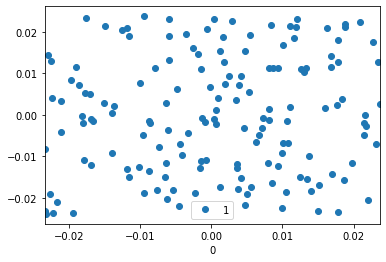

In [333]:
item_embeddings_df.plot(x=0,y=1,style='o')

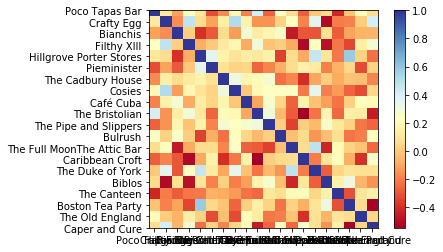

In [334]:
df_similarities_places = df_similarities_places.astype('Float64')
plt.imshow(df_similarities_places.iloc[0:20,0:20],cmap='RdYlBu')
plt.colorbar()
plt.xticks(range(len(df_similarities_places.iloc[0:20,0:20])), df_similarities_places.iloc[0:20,0:20].columns)
plt.yticks(range(len(df_similarities_places.iloc[0:20,0:20])), df_similarities_places.iloc[0:20,0:20].index)
plt.show()

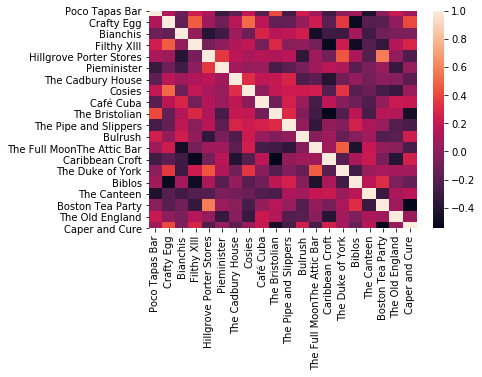

In [335]:
ax = sns.heatmap(df_similarities_places.iloc[0:20,0:20])